# MNIST dataset sınıflandırma

In [2]:
try:
    import os
    import numpy as np
    import scipy as sp
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import StratifiedShuffleSplit
    from sklearn.externals import joblib
    import matplotlib.pyplot as plt
    import pandas
    import numpy as np
    import base64
    from flask import Flask, request, render_template, make_response
    from sklearn.externals import joblib
    from io import BytesIO
    from skimage import io as skio
    from skimage.transform import resize
    
except ImportError as e:
    !pip install matplotlib
    !pip install scipy
    !pip install sklearn
    !pip install flask
    !pip install scikit-image
%matplotlib inline
np.random.seed(42)

## Veriyi Çekme

In [3]:
os.system('wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')
os.system('wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz')
os.system('wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz')
os.system('wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz')
os.system('gunzip *.gz')

512

## Veriyi Numpy Dizisine Çevirme

In [4]:
with open("train-images-idx3-ubyte", "rb") as f:
    X = np.frombuffer(f.read(), dtype=np.uint8, offset=16).copy()
    X = X.reshape((60000, 28*28))

In [5]:
with open("train-labels-idx1-ubyte", "rb") as f:
    y = np.frombuffer(f.read(), dtype=np.uint8, offset=8)

## 9 Örnek Veri

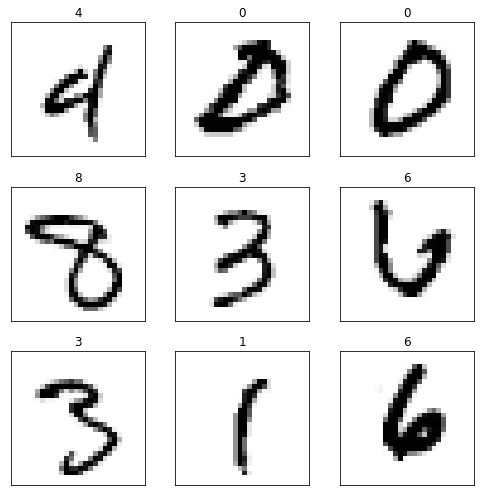

In [6]:
ind = np.random.randint(0, 60000, 9)
X_vis = X[ind, :].reshape(9, 28, 28) 
y_vis = y[ind]
plt.figure(figsize=(7, 7))
for i in range(1,3):
    for j in range(1, 9):
        plt.subplot(3, 3, (i-1)+j)
        plt.imshow(X_vis[(i-1)+j-1], cmap=plt.cm.Greys)
        plt.gca().xaxis.set_ticks([])
        plt.gca().yaxis.set_ticks([])
        plt.title(y_vis[(i-1)+j-1])
        
plt.tight_layout()
plt.show()

## Datasetin ayrılması 
### Eğitim, test ve doğrulama kümelerinin oluşturulması.

In [7]:
katmanli_ayirma = StratifiedShuffleSplit(n_splits=1, test_size=0.3)
ind = katmanli_ayirma.split(X, y)
for train_index, val_index in ind:
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

In [8]:
print('Training data: ', X_train.shape, y_train.shape)
print('Test data: ', X_train.shape, y_train.shape)

Training data:  (42000, 784) (42000,)
Test data:  (42000, 784) (42000,)


In [9]:
clf = RandomForestClassifier(n_estimators=10, criterion='entropy', n_jobs=-1, random_state=42)
clf.fit(X_train, y_train)
print('Doğruluk oranı : %{}'.format(100*sum(y_val == clf.predict(X_val))/y_val.shape[0]))

Doğruluk oranı : %94.03888888888889


In [10]:
scores = []
trees =  [5, 10, 20, 30, 40, 50, 60, 100, 300]
for n_trees in trees:
    clf = RandomForestClassifier(n_estimators=n_trees, n_jobs=-1, random_state=42)
    clf.fit(X_train, y_train)
    scores.append(100*sum(y_val == clf.predict(X_val))/y_val.shape[0])

KeyboardInterrupt: 

In [ ]:
plt.figure()
plt.plot(trees, scores)
plt.plot([trees[np.argmax(scores)]], [max(scores)], 'ro')
plt.xlabel('Agac Sayısı')
plt.ylabel('Dogruluk Oranı (%)')
plt.xlim(min(trees)-10, max(trees)+10)
plt.show()

In [111]:
print('En uygun agac sayısı:', trees[np.argmax(scores)])
print('En iyi skor: ', max(scores))

En uygun agac sayısı: 300
En iyi skor:  96.5777777778


## Tüm verilerle yeniden eğitim

In [ ]:
clf = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)
clf.fit(X, y)

### Tüm test verileri ile doğruluk oranı hesabı

In [ ]:
with open("t10k-images-idx3-ubyte", "rb") as f:
    X_test = np.frombuffer(f.read(), dtype=np.uint8, offset=16).copy()  
    X_test = X_test.reshape((10000, 28*28))
    
with open("t10k-labels-idx1-ubyte", "rb") as f:
    y_test = np.frombuffer(f.read(), dtype=np.uint8, offset=8)

In [12]:
print('Dogruluk oranı : %{}'.format(100*sum(y_test == clf.predict(X_test))/y_test.shape[0]))

NotFittedError: Estimator not fitted, call `fit` before exploiting the model.

In [14]:
clf = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)
clf.fit(np.vstack((X, X_test)), np.hstack((y, y_test)))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

## Modelin kaydedilmesi

In [23]:
joblib.dump(clf, 'clf.pkl')

['clf.pkl']

In [13]:
# %load digits_classifier/srv.py
import numpy as np
import base64

from flask import Flask, request, render_template, make_response
from sklearn.externals import joblib
from io import BytesIO
from skimage import io as skio
from skimage.transform import resize
from utils import make_mnist

app = Flask(__name__, static_url_path='/static')
clf = joblib.load('clf.pkl')


@app.route('/')
def display_gui():
    return render_template('template.html')

@app.route('/recognizer', methods=['POST'])
def recognize():
    data = request.get_json(silent=True)['image']
    data = data[22:]

    img = skio.imread(BytesIO(base64.b64decode(data)))[:,:,3]

    img = make_mnist(img)

    number = clf.predict(img.reshape(1, -1))[0]

    return make_response(str(number),200)


In [15]:
app.run()

 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [03/Mar/2017 01:26:30] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [03/Mar/2017 01:26:30] "GET /static/jquery.min.js HTTP/1.1" 304 -
127.0.0.1 - - [03/Mar/2017 01:26:30] "GET /static/bootstrap.min.css HTTP/1.1" 304 -
127.0.0.1 - - [03/Mar/2017 01:26:30] "GET /static/bootstrap-theme.min.css HTTP/1.1" 304 -
127.0.0.1 - - [03/Mar/2017 01:26:30] "GET /static/bootstrap.min.js HTTP/1.1" 304 -
127.0.0.1 - - [03/Mar/2017 01:26:30] "GET /static/sketch.min.js HTTP/1.1" 304 -
127.0.0.1 - - [03/Mar/2017 01:26:35] "POST /recognizer HTTP/1.1" 200 -
127.0.0.1 - - [03/Mar/2017 01:26:43] "POST /recognizer HTTP/1.1" 200 -
